# Video_extractor


In [2]:
import re
import requests
from urllib.parse import parse_qs,urlparse
import json

def extract_video_id(url):
    """Extract video ID from various YouTube URL formats."""
    if not url:
        return None
    
    # Clean the URL
    url = url.strip()
    
    # Add protocol if missing
    if not url.startswith(('http://', 'https://')):
        url = 'https://' + url
    
    # Different YouTube URL patterns
    patterns = [
        r'(?:youtube\.com\/watch\?v=|youtu\.be\/|youtube\.com\/embed\/|youtube\.com\/v\/|youtube\.com\/e\/|youtube\.com\/watch\?.*v=|youtube\.com\/watch\?.*&v=)([^&?#]+)',
        r'youtube\.com\/shorts\/([^&?#]+)'
    ]
    
    for pattern in patterns:
        match = re.search(pattern, url)
        if match:
            return match.group(1)
        

    # If all patterns fail, try parsing the URL directly
    parsed_url = urlparse(url)
    if 'youtube.com' in parsed_url.netloc:
        if 'watch' in parsed_url.path:
            query = parse_qs(parsed_url.query)
            if 'v' in query:
                return query['v'][0]
        elif '/shorts/' in parsed_url.path:
            path_parts = parsed_url.path.split('/')
            for i, part in enumerate(path_parts):
                if part == 'shorts' and i+1 < len(path_parts):
                    return path_parts[i+1]
                    
    return None

def get_video_platform(url):
    """Determine the platform from the URL."""
    if not url:
        return "Unknown"
        
    # Normalize the URL
    url = url.strip().lower()
    
    if "youtube.com" in url or "youtu.be" in url:
        return "YouTube"
    elif "instagram.com" in url:
        return "Instagram"
    elif "linkedin.com" in url:
        return "LinkedIn"
    elif "facebook.com" in url or "fb.com" in url:
        return "Facebook"
    elif "tiktok.com" in url:
        return "TikTok"
    elif "twitter.com" in url or "x.com" in url:
        return "Twitter"
    else:
        return "Unknown"
    
def get_youtube_metadata(video_id):
    """Get metadata for a YouTube video with fallback mechanisms."""
    
    # Fallback with basic info that will always work
    basic_metadata = {
        "title": f"YouTube Video ({video_id})",
        "description": "",
        "thumbnail_url": f"https://img.youtube.com/vi/{video_id}/hqdefault.jpg",
        "duration": 300,  # Default 5 minutes
        "views": 0,
        "author": "YouTube Creator",
        "platform": "YouTube",
        "video_id": video_id
    }

    # Try multiple methods to get the most information
    try:
        # Method 1: Try direct page HTML scraping
        url = f"https://www.youtube.com/watch?v={video_id}"
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36",
            "Accept-Language": "en-US,en;q=0.9"
        }
        
        response = requests.get(url, headers=headers)
        
        if response.status_code == 200:
            html_content = response.text
            
            # Extract title
            title_match = re.search(r'<meta property="og:title" content="([^"]+)"', html_content)
            if title_match:
                basic_metadata["title"] = title_match.group(1)
                
            # Extract author/channel
            author_match = re.search(r'<link itemprop="name" content="([^"]+)"', html_content)
            if author_match:
                basic_metadata["author"] = author_match.group(1)
                
            # Try to extract description
            description_match = re.search(r'<meta property="og:description" content="([^"]+)"', html_content)
            if description_match:
                basic_metadata["description"] = description_match.group(1)
            
            # Try to extract duration
            duration_match = re.search(r'"lengthSeconds":"(\d+)"', html_content)
            if duration_match:
                try:
                    basic_metadata["duration"] = int(duration_match.group(1))
                except ValueError:
                    pass  # Use default duration
            
            # Try to extract view count
            views_match = re.search(r'"viewCount":"(\d+)"', html_content)
            if views_match:
                try:
                    basic_metadata["views"] = int(views_match.group(1))
                except ValueError:
                    pass  # Use default views
            
            # Extract higher quality thumbnail if available
            thumbnail_match = re.search(r'<meta property="og:image" content="([^"]+)"', html_content)
            if thumbnail_match:
                basic_metadata["thumbnail_url"] = thumbnail_match.group(1)

        # Method 2: Try to get more info from oEmbed API
        try:
            oembed_url = f"https://www.youtube.com/oembed?url=https://www.youtube.com/watch?v={video_id}&format=json"
            oembed_response = requests.get(oembed_url)
            
            if oembed_response.status_code == 200:
                oembed_data = oembed_response.json()
                
                # Update metadata with oembed data
                if 'title' in oembed_data and oembed_data['title']:
                    basic_metadata["title"] = oembed_data['title']
                
                if 'author_name' in oembed_data and oembed_data['author_name']:
                    basic_metadata["author"] = oembed_data['author_name']
                
                if 'thumbnail_url' in oembed_data and oembed_data['thumbnail_url']:
                    # Only update if it's higher quality
                    if 'maxresdefault' in oembed_data['thumbnail_url']:
                        basic_metadata["thumbnail_url"] = oembed_data['thumbnail_url']
        except:
            # Ignore any errors with this optional step
            pass
            
    except Exception as e:
        print(f"Error extracting YouTube metadata: {e}")
        # If there's any error, just use the basic metadata
        pass
        
    return basic_metadata

    
def get_video_metadata(url):
    """Get video metadata based on the platform."""
    if not url:
        raise ValueError("Please enter a video URL")
    
    # Determine platform
    platform = get_video_platform(url)
    
    # Currently we only support full metadata extraction for YouTube
    if platform == "YouTube":
        # Extract video ID from URL
        video_id = extract_video_id(url)
        
        if not video_id:
            raise ValueError("Could not extract video ID from URL. Please use a standard YouTube URL.")
        
        return get_youtube_metadata(video_id)
    else:
        # For other platforms, just return basic info
        return {
            "title": "Video on " + platform,
            "description": "",
            "thumbnail_url": "https://via.placeholder.com/1280x720.png?text=" + platform,
            "duration": 300,  # Default 5 minutes
            "views": 0,
            "author": platform + " Creator",
            "platform": platform,
            "video_id": "unknown"
        }
    



# Thumbnails

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
import os
import colorsys
import math
import gradio as gr
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline, DDIMScheduler



device="cuda" if torch.cuda.is_available() else "cpu"
def general_prompt(prompt,negative_prompt,
                #    pipe_name="runwayml/stable-diffusion-v1-5"
                   
                   height,width,
                   pipe_name="stabilityai/stable-diffusion-2-1"
                   ):
    pipe = StableDiffusionPipeline.from_pretrained(pipe_name).to(device)
    pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
    im = pipe(prompt, negative_prompt=negative_prompt).images[0]
    im.resize((width,height))
    # im.show() 
    path=f"{prompt}.png"
    im.save(path)
    # torch.cuda.empty_cache()

    # print(im)
    return im,path

def generate_thumbnail_with_dalle(client, concept, video_title, platform="YouTube"):
    """Generate a thumbnail image using DALL-E based on the concept and video title."""
    try:
        # Define aspect ratio based on platform
        if platform == "YouTube":
            aspect_ratio = "16:9"
            size = "1792x1024"  # DALL-E supports 1792x1024 which is close to 16:9
        elif platform == "Instagram":
            aspect_ratio = "1:1"
            size = "1024x1024"  # Square format for Instagram
        elif platform == "LinkedIn":
            aspect_ratio = "1.91:1"
            size = "1792x1024"  # Using same as YouTube for now
        else:
            aspect_ratio = "16:9"  # Default to YouTube ratio
            size = "1792x1024"
            
        # Extract key elements from the concept
        text_overlay = concept.get('text_overlay', '')
        focal_point = concept.get('focal_point', '')
        tone = concept.get('tone', '')
        concept_desc = concept.get('concept', '')
        
        # Get colors for text if available
        colors = concept.get('colors', ['#FFFFFF', '#000000'])
        main_color = colors[0] if len(colors) > 0 else '#FFFFFF'
        
        # Craft a detailed prompt for DALL-E that includes the text overlay
        prompt = f"""
        Create a professional {platform} thumbnail with these specifications:
        - Clear {aspect_ratio} format for {platform}
        - Main focus: {focal_point}
        - Emotional tone: {tone}
        - Bold, clear text overlay reading "{text_overlay}" prominently displayed
        - Text should be highly legible, possibly in color {main_color} with contrasting outline
        - Concept: {concept_desc}
        - Related to: {video_title}
        - Professional, eye-catching design with high contrast
        - Make sure the text stands out and is easily readable
        - Thumbnail should look professional and high-quality for {platform}
        - Text should be integrated with the visual elements in a visually appealing way
        """
        
        # Generate the image with DALL-E
        response = client.images.generate(
            model="dall-e-3",
            prompt=prompt,
            size=size,
            quality="standard",
            n=1,
        )
        
        # Get the image URL
        image_url = response.data[0].url
        return image_url
    
    except Exception as e:
        print(f"Error generating thumbnail with DALL-E: {e}")
        return None

import requests






def generate_thumbnail_with_hf(client, concept, video_title, platform="YouTube"):
    """Generate a thumbnail image using Hugging Face models based on the concept and video title."""
    try:
        # Define aspect ratio based on platform
        if platform == "YouTube":
            aspect_ratio = "16:9"
            size = "1792x1024"  # DALL-E supports 1792x1024 which is close to 16:9
        elif platform == "Instagram":
            aspect_ratio = "1:1"
            size = "1024x1024"  # Square format for Instagram
        elif platform == "LinkedIn":
            aspect_ratio = "1.91:1"
            size = "1792x1024"  # Using same as YouTube for now
        else:
            aspect_ratio = "16:9"  # Default to YouTube ratio
            size = "1792x1024"

        # Extract key elements from the concept
        text_overlay = concept.get('text_overlay', '')
        focal_point = concept.get('focal_point', '')
        tone = concept.get('tone', '')
        concept_desc = concept.get('concept', '')
        # Get colors for text if available
        colors = concept.get('colors', ['#FFFFFF', '#000000'])
        main_color = colors[0] if len(colors) > 0 else '#FFFFFF'

        # Craft a detailed prompt for Hugging Face that includes the text overlay
        prompt = f"""
        Create a professional {platform} thumbnail with these specifications:
        - Clear {aspect_ratio} format for {platform}
        - Main focus: {focal_point}
        - Emotional tone: {tone}
        - Bold, clear text overlay reading "{text_overlay}" prominently displayed
        - Text should be highly legible, possibly in color {main_color} with contrasting outline
        - Concept: {concept_desc}
        - Related to: {video_title}
        - Professional, eye-catching design with high contrast
        - Make sure the text stands out and is easily readable
        - Thumbnail should look professional and high-quality for {platform}
        - Text should be integrated with the visual elements in a visually appealing way
        """

        # Generate the image using Hugging Face models (example API call)
        # response = client.generate_image(prompt=prompt, width=int(size.split('x')[0]), height=int(size.split('x')[1]))
        image,path=general_prompt(prompt=prompt,negative_prompt="Blurry and Distorted Image",height=int(size.split('x')[1]),width=int(size.split('x')[0]))

        # Get the image URL
        # image_url = response.url
        # return image_url
        return image,path

    except Exception as e:
        print(f"Error generating thumbnail with Hugging Face models: {e}")
        return None,None

def create_gradient_background(concept, width=1280, height=720):
    """Create a gradient background using the colors from the concept."""
    # Get colors from concept, or use defaults
    colors = concept.get('colors', ['#3366CC', '#FFFFFF', '#FF5555'])
    
    # Ensure we have at least two colors
    if len(colors) < 2:
        colors.append('#FFFFFF')
    
    # Parse hex colors to RGB
    try:
        color1 = hex_to_rgb(colors[0])
        color2 = hex_to_rgb(colors[1] if len(colors) > 1 else '#FFFFFF')
    except:
        # Fallback to default colors if parsing fails
        color1 = (51, 102, 204)  # #3366CC
        color2 = (255, 255, 255)  # #FFFFFF
    
    # Create a new image
    img = Image.new('RGB', (width, height), color=color1)
    draw = ImageDraw.Draw(img)
    
    # Create gradient
    for y in range(height):
        # Calculate ratio of current position
        ratio = y / height
        
        # Interpolate between the two colors
        r = int(color1[0] * (1 - ratio) + color2[0] * ratio)
        g = int(color1[1] * (1 - ratio) + color2[1] * ratio)
        b = int(color1[2] * (1 - ratio) + color2[2] * ratio)
        
        # Draw a line with the interpolated color
        draw.line([(0, y), (width, y)], fill=(r, g, b))
    
    # Add a subtle pattern based on the tone
    tone = concept.get('tone', '').lower()
    if 'professional' in tone or 'educational' in tone:
        add_professional_pattern(img, draw)
    elif 'energetic' in tone or 'exciting' in tone:
        add_energetic_pattern(img, draw)
    elif 'emotional' in tone or 'dramatic' in tone:
        add_dramatic_pattern(img, draw)
    
    return img



def add_text_with_outline(img, draw, concept):
    """Add text overlay with outline for better visibility."""
    text = concept.get('text_overlay', 'THUMBNAIL')
    colors = concept.get('colors', ['#FFFFFF', '#000000'])
    
    # Get text color and outline color
    text_color = colors[0] if len(colors) > 0 else '#FFFFFF'
    outline_color = colors[1] if len(colors) > 1 else '#000000'
    
    # Parse hex colors to RGB
    try:
        text_rgb = hex_to_rgb(text_color)
        outline_rgb = hex_to_rgb(outline_color)
    except:
        # Fallback colors
        text_rgb = (255, 255, 255)
        outline_rgb = (0, 0, 0)
    
    # Try to use a font if available
    try:
        # Try common system fonts
        system_fonts = ['arial.ttf', 'Arial.ttf', 'Verdana.ttf', 'verdana.ttf', 
                        'impact.ttf', 'Impact.ttf', 'Tahoma.ttf', 'tahoma.ttf']
        
        font = None
        for font_name in system_fonts:
            try:
                font = ImageFont.truetype(font_name, 80)
                break
            except IOError:
                continue
        
        # If no system font is found, use default
        if font is None:
            font = ImageFont.load_default().font_variant(size=80)
    except:
        # Fallback to default font
        font = ImageFont.load_default()
    
    # Get text size for centering
    try:
        _, _, text_width, text_height = draw.textbbox((0, 0), text, font=font)
    except:
        # Estimate size if method not available
        text_width = len(text) * 40
        text_height = 80
    
    # Calculate text position (centered by default)
    position = (
        (img.width - text_width) // 2,
        (img.height - text_height) // 2
    )
    
    # Check if composition indicates different text placement
    composition = concept.get('composition', '').lower()
    if 'top' in composition:
        position = (position[0], img.height // 4)
    elif 'bottom' in composition:
        position = (position[0], img.height * 3 // 4)
    elif 'left' in composition:
        position = (img.width // 4, position[1])
    elif 'right' in composition:
        position = (img.width * 3 // 4 - text_width, position[1])
    
    # Draw text outline
    outline_size = 3
    for x_offset in range(-outline_size, outline_size + 1, outline_size):
        for y_offset in range(-outline_size, outline_size + 1, outline_size):
            draw.text(
                (position[0] + x_offset, position[1] + y_offset),
                text,
                font=font,
                fill=outline_rgb
            )
    
    # Draw main text
    draw.text(
        position,
        text,
        font=font,
        fill=text_rgb
    )

def add_watermark(img, draw):
    """Add a subtle watermark to the image."""
    watermark_text = "Video SEO Optimizer"
    try:
        font = ImageFont.truetype('arial.ttf', 20)
    except:
        font = ImageFont.load_default()
    
    # Draw watermark in bottom right corner
    draw.text(
        (img.width - 220, img.height - 30),
        watermark_text,
        fill=(255, 255, 255, 128),
        font=font
    )

def add_professional_pattern(img, draw):
    """Add a subtle professional pattern to the background."""
    width, height = img.size
    
    # Draw subtle lines
    for i in range(0, width, 40):
        draw.line([(i, 0), (i, height)], fill=(255, 255, 255, 10))
    
    for i in range(0, height, 40):
        draw.line([(0, i), (width, i)], fill=(255, 255, 255, 10))

def add_energetic_pattern(img, draw):
    """Add an energetic pattern to the background."""
    width, height = img.size
    
    # Draw diagonal lines
    for i in range(-height, width + height, 60):
        draw.line([(i, 0), (i + height, height)], fill=(255, 255, 255, 15))
        draw.line([(i, height), (i + height, 0)], fill=(255, 255, 255, 15))

def add_dramatic_pattern(img, draw):
    """Add a dramatic pattern to the background."""
    width, height = img.size
    center_x, center_y = width // 2, height // 2
    
    # Draw concentric circles
    for radius in range(50, max(width, height), 100):
        draw.arc(
            [(center_x - radius, center_y - radius), 
             (center_x + radius, center_y + radius)],
            0, 360, fill=(255, 255, 255, 20)
        )

def hex_to_rgb(hex_color):
    """Convert hex color code to RGB tuple."""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))




def create_thumbnail_preview(concept, video_title, base_image_url=None):
    """
    Create a thumbnail preview based on concept description.
    This generates a basic visualization when DALL-E is not available.
    """
    # If we have a base image URL (like YouTube thumbnail), we can use it
    if base_image_url:
        try:
            response = requests.get(base_image_url)
            img = Image.open(BytesIO(response.content))
            # Resize to standard thumbnail size if needed
            img = img.resize((1280, 720))
        except Exception:
            # Fallback to creating a blank image
            img = create_gradient_background(concept)
    else:
        # Create a background with gradient using the concept colors
        img = create_gradient_background(concept)
    
    # Create a drawing context
    draw = ImageDraw.Draw(img)
    
    # Add text overlay if specified
    if concept.get('text_overlay'):
        add_text_with_outline(img, draw, concept)
    
    # Add a subtle watermark
    add_watermark(img, draw)
    
    return img





In [18]:
im,path=general_prompt("car","Blurry Image",512,512,pipe_name="city96/flux.1-lite-8B-alpha-gguf")

EntryNotFoundError: 404 Client Error. (Request ID: Root=1-6820b049-29ab79776120a5d660409d19;77ac45e5-63f2-4c0b-a4c3-c27b3c3571d6)

Entry Not Found for url: https://huggingface.co/city96/flux.1-lite-8B-alpha-gguf/resolve/main/model_index.json.

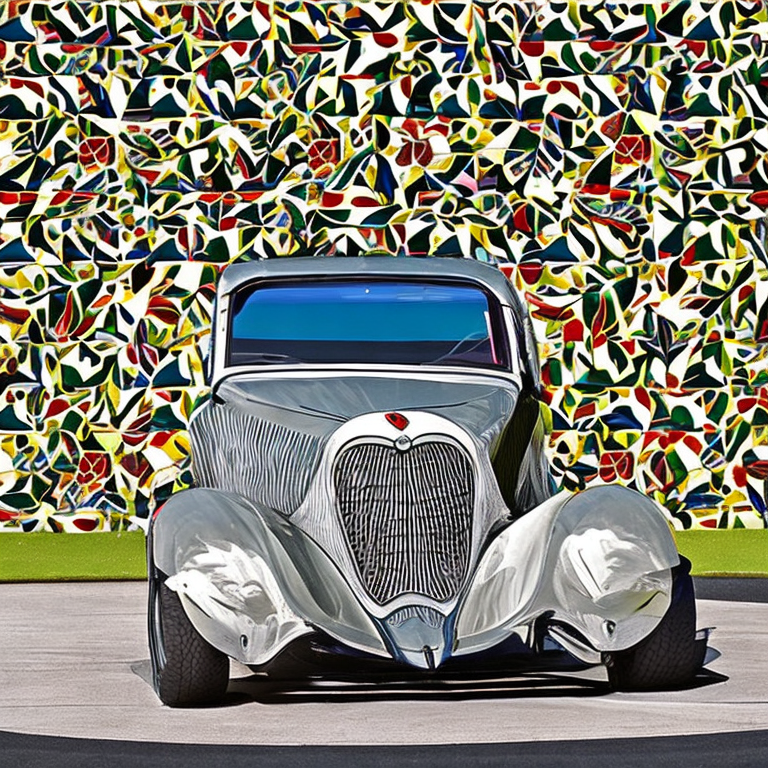

In [17]:
im

In [ ]:
# import torch
# from diffusers import StableDiffusionXLPipeline
# from PIL import Image

# # Use the correct model path
# model_id = "RunDiffusion/Juggernaut-XL-v7"

# # Load the pipeline without fp16 variant or safetensors
# pipe = StableDiffusionXLPipeline.from_pretrained(
#     model_id,
#     torch_dtype=torch.float16  # or torch.float32 if this gives issues
# ).to("cuda")

# # Enable memory-efficient attention
# pipe.enable_xformers_memory_efficient_attention()

# # Define prompts
# prompt = "a futuristic cityscape at sunset, ultra-detailed, cinematic lighting, 4k"
# negative_prompt = "blurry, low quality, distorted, extra limbs"

# # Generate image
# image = pipe(
#     prompt=prompt,
#     negative_prompt=negative_prompt,
#     guidance_scale=7.5,
#     num_inference_steps=30,
#     height=1024,
#     width=1024
# ).images[0]

# # Save image
# image.save("juggernaut_xl_output.png")


Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

: 

: 

# seo_agents

In [5]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser
from langchain.schema import AgentAction, AgentFinish, HumanMessage, SystemMessage
from langchain_ollama import OllamaLLM,ChatOllama
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI
import json
import re
import os


def get_seo_output_parser():
    """Create a structured output parser for SEO recommendations."""
    response_schemas = [
        ResponseSchema(name="tags", 
                      description="A list of exactly 35 relevant hashtags/tags for the video"),
        ResponseSchema(name="description", 
                      description="An SEO-optimized video description between 400-500 words"),
        ResponseSchema(name="timestamps", 
                      description="A list of timestamp objects with 'time' and 'description' fields more the 5 timestamps of the video"),
        ResponseSchema(name="titles", 
                      description="A list of title suggestion objects with 'rank', 'title', and 'reason' fields")
    ]
    return StructuredOutputParser.from_response_schemas(response_schemas)


def get_thumbnail_output_parser():
    """Create a structured output parser for thumbnail recommendations."""
    response_schemas = [
        ResponseSchema(name="thumbnail_concepts", 
                      description="A list of 3 thumbnail concept objects with all required fields")
    ]
    return StructuredOutputParser.from_response_schemas(response_schemas)

def run_seo_analysis_with_langchain(video_url, video_metadata, language="English",llm_name="Ollama",model=None):
    """Run a complete SEO analysis using LangChain agents."""
    # if not os.environ.get("OPENAI_API_KEY"):
    #     raise Exception("OpenAI API key is required for analysis")
    
    # Initialize ChatOpenAI model
    if llm_name=="OpenAI":
        if model==None:
            llm = ChatOpenAI(model="gpt-4o")
        else :
            llm = ChatOpenAI(model=model)

    elif llm_name=="Ollama":
        if model==None:
            llm=ChatOllama(model="llama3.2")
        else:
            llm=ChatOllama(model=model)


    elif llm_name=="Gemini":
        if model==None:
            llm=ChatGoogleGenerativeAI(model="gemini-2.0-flash")
        else:
            llm=ChatGoogleGenerativeAI(model=model)
    elif llm_name=="Groq":
        if model==None:
            llm=ChatGroq(model="llama-3.1-8b-instant")
        else:
            llm = ChatGroq(model=model)
    # llm = ChatOpenAI(temperature=0.7, model="gpt-4")
    
    # Setup for analysis
    platform = video_metadata.get('platform', 'YouTube')
    title = video_metadata.get('title', '')
    duration = video_metadata.get('duration', 0)
    minutes = duration // 60
    num_timestamps = min(15, max(5, int(minutes / 2))) if minutes > 0 else 5
    
    # Step 1: Video content analysis
    analysis_template = """
    You are a video content analyst specialized in understanding {platform} videos, their structure, and audience appeal.
    
    Analyze the {platform} video at {video_url} with title "{title}".
    
    Provide a detailed analysis including:
    1. A summary of the video content (based on the title and any metadata)
    2. Main topics likely covered (at least 5 specific topics)
    3. Emotional tone and style of the video
    4. Target audience demographics and interests
    5. Content structure and flow
    
    Your analysis should be in {language} language.
    Make reasonable assumptions based on the available information.
    """
    
    analysis_prompt = PromptTemplate(
        input_variables=["platform", "video_url", "title", "language"],
        template=analysis_template
    )
    
    analysis_chain = LLMChain(
        llm=llm,
        prompt=analysis_prompt
    )
    
    analysis_result = analysis_chain.run(
        platform=platform,
        video_url=video_url,
        title=title,
        language=language
    )



    # Step 2: SEO recommendations
    seo_output_parser = get_seo_output_parser()
    seo_format_instructions = seo_output_parser.get_format_instructions()
    
    seo_template = """
    You are an SEO specialist focusing on optimizing {platform} content for maximum discovery and engagement.
    
    Based on this analysis of a {platform} video titled "{title}":
    
    {analysis}
    
    Generate comprehensive SEO recommendations optimized specifically for {platform} including:
    
    1. EXACTLY 35 trending hashtags/tags related to the video content, ranked by potential traffic and relevance. 
       For {platform}, optimize the tags according to platform best practices.
    
    2. Detailed and SEO-optimized video description (400-500 words) that includes:
       - An engaging hook in the first 2-3 sentences that entices viewers
       - A clear value proposition explaining what viewers will gain
       - Key topics covered with strategic keyword placement
       - A strong call-to-action appropriate for {platform}
       - Essential links (placeholder)
       - Proper formatting with paragraph breaks for readability
    
    3. Exactly {num_timestamps} timestamps with descriptive labels evenly distributed throughout the video (duration: {duration} seconds)
    
    4. 5-7 alternative title suggestions ranked by SEO potential, each under 60 characters for YouTube or appropriate length for {platform}
    
    {format_instructions}
    
    All content should be in {language} language.
    """
    
    seo_prompt = PromptTemplate(
        input_variables=["platform", "title", "analysis", "num_timestamps", "duration", "language"],
        partial_variables={"format_instructions": seo_format_instructions},
        template=seo_template
    )
    
    seo_chain = LLMChain(
        llm=llm,
        prompt=seo_prompt
    )
    
    seo_result = seo_chain.run(
        platform=platform,
        title=title,
        analysis=analysis_result,
        num_timestamps=num_timestamps,
        duration=duration,
        language=language
    )
    
    # Parse the SEO results
    try:
        # Try to extract JSON from the text
        seo_data = parse_langchain_output(seo_result)
        
        # Ensure we have exactly 35 tags
        if len(seo_data.get("tags", [])) != 35:
            # Call helper function to generate more tags if needed
            seo_data["tags"] = ensure_35_tags(seo_data.get("tags", []), llm, title, platform, language)
    except Exception:
        # Fallback to basic structure if parsing fails
        seo_data = generate_fallback_seo(title, platform, language)
    
    # Step 3: Thumbnail concepts
    thumbnail_output_parser = get_thumbnail_output_parser()
    thumbnail_format_instructions = thumbnail_output_parser.get_format_instructions()
    
    thumbnail_template = """
    You are a professional thumbnail designer specialized in creating engaging {platform} thumbnails that maximize click-through rates.
    
    Based on this analysis of a {platform} video titled "{title}":
    
    {analysis}
    
    Create 3 detailed thumbnail concepts specifically optimized for {platform}.
    
    For each concept, provide:
    1. The main visual elements to include (very specific and detailed)
    2. Text overlay suggestions (maximum 3-5 words, optimized for {platform})
    3. Color scheme (with exact hex codes for 3 colors)
    4. Focal point/main subject (detailed description of what should be the center of attention)
    5. Emotional tone the thumbnail should convey
    6. Composition details (layout, text placement, foreground/background elements)
    
    {format_instructions}
    
    All content should be in {language} language.
    """
    
    thumbnail_prompt = PromptTemplate(
        input_variables=["platform", "title", "analysis", "language"],
        partial_variables={"format_instructions": thumbnail_format_instructions},
        template=thumbnail_template
    )
    
    thumbnail_chain = LLMChain(
        llm=llm,
        prompt=thumbnail_prompt
    )
    
    thumbnail_result = thumbnail_chain.run(
        platform=platform,
        title=title,
        analysis=analysis_result,
        language=language
    )
    
    # Parse the thumbnail results
    try:
        # Try to extract JSON from the text
        thumbnail_data = parse_langchain_output(thumbnail_result)
    except Exception:
        # Fallback to basic structure if parsing fails
        thumbnail_data = generate_fallback_thumbnails(platform, language)
    
    # Return the combined results
    return {
        "analysis": analysis_result,
        "seo": seo_data,
        "thumbnails": thumbnail_data
    }

def parse_langchain_output(output_text):
    """Parse the output from LangChain, handling various formats."""
    # First, try to parse as pure JSON
    try:
        return json.loads(output_text)
    except json.JSONDecodeError:
        # Try to extract JSON from markdown code blocks
        json_pattern = r"```json\s*([\s\S]*?)\s*```"
        match = re.search(json_pattern, output_text)
        if match:
            try:
                return json.loads(match.group(1))
            except json.JSONDecodeError:
                pass
        
        # Try to extract JSON from the text using regex patterns
        json_start = output_text.find('{')
        json_end = output_text.rfind('}') + 1
        if json_start >= 0 and json_end > json_start:
            try:
                return json.loads(output_text[json_start:json_end])
            except json.JSONDecodeError:
                pass
        
        # If all parsing attempts fail, raise an error
        raise ValueError("Could not parse output as JSON")

def ensure_35_tags(tags, llm, title, platform, language):
    """Ensure we have exactly 35 tags using LangChain."""
    current_count = len(tags)
    
    if current_count == 35:
        return tags
    
    if current_count < 35:
        # Generate more tags
        more_tags_template = """
        Based on these existing tags for a {platform} video about "{title}":
        {tags}
        
        Generate {num_needed} additional relevant and trending tags in {language}.
        Return ONLY a JSON array with the new tags.
        """
        
        more_tags_prompt = PromptTemplate(
            input_variables=["platform", "title", "tags", "num_needed", "language"],
            template=more_tags_template
        )
        
        more_tags_chain = LLMChain(
            llm=llm,
            prompt=more_tags_prompt
        )
        
        try:
            more_tags_result = more_tags_chain.run(
                platform=platform,
                title=title,
                tags=tags,
                num_needed=35 - current_count,
                language=language
            )
            
            # Parse the additional tags
            try:
                additional_tags = parse_langchain_output(more_tags_result)
                if isinstance(additional_tags, list):
                    tags.extend(additional_tags[:35 - current_count])
                else:
                    # Handle case where we get an object with a key instead of direct array
                    for key in additional_tags:
                        if isinstance(additional_tags[key], list):
                            tags.extend(additional_tags[key][:35 - current_count])
                            break
            except:
                # Add generic tags if parsing fails
                for i in range(current_count, 35):
                    tags.append(f"related_tag_{i}")
        except:
            # Add generic tags if LangChain fails
            for i in range(current_count, 35):
                tags.append(f"related_tag_{i}")
    
    elif current_count > 35:
        # Truncate to exactly 35
        tags = tags[:35]
    
    return tags

def generate_fallback_seo(title, platform, language):
    """Generate fallback SEO content if parsing fails."""
    # Generate 35 YouTube-specific tags
    youtube_tags = ["youtube", "video", "tutorial", "vlog", "howto", 
                   "review", "explained", "educational", "learn", "step by step",
                   "beginner", "advanced", "masterclass", "course", "lesson",
                   "strategy", "technique", "demonstration", "walkthrough", "overview",
                   "comparison", "versus", "top", "best", "recommended",
                   "trending", "viral", "popular", "interesting", "amazing",
                   "helpful", "useful", "informative", "detailed", "comprehensive"]
    
    return {
        "tags": youtube_tags,
        "description": f"This YouTube video about {title} provides valuable information and insights. Watch to learn more about this topic.\n\nDon't forget to like, comment, and subscribe for more content!\n\n#YouTube #Tutorial",
        "timestamps": [{"time": "00:00", "description": "Introduction"}],
        "titles": [
            {"rank": 1, "title": title, "reason": "Original title"},
            {"rank": 2, "title": f"Complete Guide to {title}", "reason": "Informative variant"},
            {"rank": 3, "title": f"How to {title} | Step by Step Tutorial", "reason": "Tutorial style"},
            {"rank": 4, "title": f"Top 10 {title} Tips You Need to Know", "reason": "List format"},
            {"rank": 5, "title": f"{title} Explained Simply", "reason": "Educational angle"}
        ]
    }

def generate_fallback_thumbnails(platform, language):
    """Generate fallback thumbnail concepts if parsing fails."""
    youtube_colors = ["#FF0000", "#FFFFFF", "#000000"]  # YouTube colors
    
    return {
        "thumbnail_concepts": [
            {
                "concept": "Professional YouTube thumbnail with text overlay",
                "text_overlay": "Ultimate Guide",
                "colors": youtube_colors,
                "focal_point": "Center of the image with clear subject",
                "tone": "Professional and educational",
                "composition": "Subject on the right, text on the left with high contrast"
            },
            {
                "concept": "Emotional reaction thumbnail with facial expression",
                "text_overlay": "You Won't Believe This!",
                "colors": youtube_colors,
                "focal_point": "Close-up of surprised face or reaction",
                "tone": "Surprising and emotionally engaging",
                "composition": "Face taking up 40% of thumbnail with text above"
            },
            {
                "concept": "Before/After comparison thumbnail",
                "text_overlay": "Transformation",
                "colors": youtube_colors,
                "focal_point": "Split screen showing clear contrast",
                "tone": "Impressive and motivational",
                "composition": "50/50 split with arrow or divider in the middle"
            }
        ]
    }



In [4]:
from langchain_ollama import ChatOllama,OllamaLLM
model=ChatOllama(model="llama3.2")
model.invoke("hi")

AIMessage(content='How can I help you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-05-11T15:25:38.9215586Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5504322500, 'load_duration': 4917652800, 'prompt_eval_count': 26, 'prompt_eval_duration': 459291900, 'eval_count': 8, 'eval_duration': 114138700, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-da862ae5-ac74-4a56-bbbd-c141131c4d2d-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})

# App

In [ ]:


import os
import streamlit as st
from openai import OpenAI
from dotenv import load_dotenv
import json
import time
import tempfile
from PIL import Image
from io import BytesIO
import requests




# Import the utility functions
from utils.video_extractor import get_video_metadata
from utils.seo_agents import run_seo_analysis_with_langchain
from utils.thumbnails import generate_thumbnail_with_dalle, create_thumbnail_preview


def get_ollama_models():
    try:
        result = subprocess.run(['ollama', 'list'], capture_output=True, text=True, check=True)
        lines = result.stdout.strip().split('\n')
        models = []

        # Skip header row (assumes first row contains column headers)
        for line in lines[1:]:
            # Typically, model name is the first column
            parts = line.split()
            if parts:
                models.append(parts[0])

        return models
    except subprocess.CalledProcessError as e:
        print("Error running 'ollama list':", e)
        print("Output:", e.stdout)
        print("Error Output:", e.stderr)

import requests

def get_all_groq_models(api_key: str) -> list:
    """
    Fetches and returns a list of all model IDs available from the Groq API.

    Args:
        api_key (str): Your Groq API key.

    Returns:
        List[str]: A list of model IDs (names).
    """
    url = "https://api.groq.com/openai/v1/models"
    headers = {
        "Authorization": f"Bearer {api_key}"
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise exception for HTTP errors
        models_data = response.json()
        return [model["id"] for model in models_data.get("data", [])]
    except requests.RequestException as e:
        print(f"Error fetching Groq models: {e}")
        return []

# Example usage:
# api_key = "your_actual_groq_api_key"
# print(get_all_groq_models(api_key))

import google.generativeai as genai
import os
def get_all_gemini_models(api_key):


    """
    Lists the names of all available Gemini models.

    Args:
        api_key: Your Google AI API key.

    Returns:
        A list of strings, where each string is the name of an available Gemini model.
        Returns an empty list if the API key is invalid or there's an error.
    """
    try:
        genai.configure(api_key=api_key)
        models = genai.list_models()
        gemini_models = [model.name for model in models if "gemini" in model.name.lower()]
        return gemini_models
    except Exception as e:
        print(f"An error occurred: {e}")
        return []


# Load environment variables
load_dotenv()

# Configure API keys from environment
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Available languages
LANGUAGES = [
    "English", "Spanish", "French", "German", "Italian", "Portuguese",
    "Hindi", "Japanese", "Korean", "Chinese", "Russian", "Arabic"
]

# Set page config
st.set_page_config(
    page_title="Video SEO Optimizer",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Apply custom CSS styling
st.markdown("""
<style>
    .main-title { font-size: 2.5rem; color: #1E88E5; margin-bottom: 1rem; }
    .section-title { font-size: 1.5rem; color: #0D47A1; margin-top: 1rem; }
    .tag-pill { background-color: #E3F2FD; color: #1565C0; padding: 5px 10px; border-radius: 15px; margin: 2px; display: inline-block; }
    .timestamp-card { background-color: #2196F3; padding: 10px; border-radius: 5px; margin-bottom: 5px; color: #FFFFFF; }
    .timestamp-card b { color: #FF5252; font-weight: bold; }
    .stButton>button { background-color: #1E88E5; color: white; }
    .platform-badge { font-weight: bold; padding: 5px 10px; border-radius: 5px; display: inline-block; margin-bottom: 10px; }
    .youtube-badge { background-color: #FF0000; color: white; }
    .thumbnail-concept { border: 1px solid #DDDDDD; border-radius: 8px; padding: 15px; margin-bottom: 15px; }
    .color-swatch { height: 25px; width: 25px; display: inline-block; margin-right: 5px; border: 1px solid #CCCCCC; }
</style>
""", unsafe_allow_html=True)




# Sidebar for API keys and info
with st.sidebar:
    st.image("https://via.placeholder.com/150x150.png?text=SEO+Agent", width=150)
    st.title("API Configuration")
    model_option=None
    openai_api_key=" "
    model_list=["Ollama","Open AI","Groq","Gemini"]
    model = st.selectbox("Select Model", model_list)
    st.subheader("Language Settings")
    selected_language = st.selectbox("Select Output Language", LANGUAGES, index=0)
    
    if model=="Open AI":
        st.write("You have selected Open AI")

        openai_api_key=st.text_input("Enter your OpenAi API key",type="password")
        st.divider()

        if openai_api_key:    
            model_option=st.selectbox(
                "Select AI Model",
                ["gpt-3.5-turbo (Fast)","gpt-4o (High Quality)"],
                help="GPT 3.5 is faster than GPT 4"
            )
            # st.subheader("Model Settings")
    
        else:
            st.warning("enter API Key")


    elif model=="Ollama":
        st.write("You have selected Ollama")
        ollama_list=get_ollama_models()

        model_option=st.selectbox(
            "Select AI Model",
            ollama_list,
            help="use models acc to the requirement "
        )
        st.divider()

        # llm=ChatOllama(model=model_Selection,base_url="http://localhost:11434", provider="ollama")
    elif model=="Groq":
        st.write("You have selected Groq")
        groqapi_key=st.text_input("Enter your Groq API key",type="password")
        st.divider()

        openai_api_key=groqapi_key
        if groqapi_key:    
            groq_list=get_all_groq_models(api_key=groqapi_key)
            model_option=st.selectbox(
                "Select AI Model",
                groq_list,
                help="use models acc to the requirement "
            )
        else:
            st.warning("enter API Key")

    elif model=="Gemini":
        st.write("You have selected Gemini")
        Geminiapi_key=st.text_input("Enter your Gemini API key",type="password")
        st.divider()

        openai_api_key=Geminiapi_key
        if Geminiapi_key:    
            gemini_list=get_all_gemini_models(api_key=Geminiapi_key)
            model_option=st.selectbox(
                "Select AI Model",
                gemini_list,
                help="use models acc to the requirement "
            )
        else:
            st.warning("enter API Key")


    # openai_api_key = st.text_input("OpenAI API Key", type="password", key="openai_key")
    
    # # Save API key to environment if provided
    # # if openai_api_key:
    # #     os.environ["OPENAI_API_KEY"] = openai_api_key
    
    # st.divider()
    
    # # Language selection
    # st.subheader("Language Settings")
    # selected_language = st.selectbox("Select Output Language", LANGUAGES, index=0)
    
    # # Model options
    # st.subheader("Model Settings")
    # model_option = st.selectbox(
    #     "Select AI Engine",
    #     ["OpenAI GPT-4", "LangChain Agent"],
    #     index=1,
    #     help="Choose between direct OpenAI API calls or a LangChain agent system"
    # )
    


    st.divider()
    st.subheader("About")
    st.write("""
    This tool uses AI to analyze videos and generate platform-specific SEO recommendations.
    
    It optimizes:
    - 35 Trending Tags
    - Detailed Descriptions
    - Strategic Timestamps
    - 5+ SEO-friendly Titles
    - Platform-optimized Thumbnails
    """)
    
    st.divider()
    st.caption("Created with OpenAI GPT-4, LangChain & Streamlit")








# Main content
st.markdown("<h1 class='main-title'>Video SEO Optimizer Pro</h1>", unsafe_allow_html=True)
st.write("Analyze videos from YouTube to generate platform-specific SEO recommendations.")



# Video URL input
video_url = st.text_input("Enter video URL", placeholder="https://www.youtube.com/watch?v=...")




# Initialize session state for storing results
if 'analysis_complete' not in st.session_state:
    st.session_state.analysis_complete = False
if 'analysis_results' not in st.session_state:
    st.session_state.analysis_results = None
if 'video_metadata' not in st.session_state:
    st.session_state.video_metadata = None
if 'video_url' not in st.session_state:
    st.session_state.video_url = ""

# Process the URL if provided
if video_url:
    st.session_state.video_url = video_url
    try:
        with st.spinner("Fetching video information..."):
            metadata = get_video_metadata(video_url)
            st.session_state.video_metadata = metadata
        
        # Display video information
        col1, col2 = st.columns([2, 1])
        
        with col1:
            st.subheader("Video Details")
            
            # Display platform badge
            platform = metadata.get('platform', 'Unknown')
            badge_class = f"{platform.lower()}-badge" if platform in ["YouTube", "Instagram", "LinkedIn"] else ""
            st.markdown(f"<div class='platform-badge {badge_class}'>{platform}</div>", unsafe_allow_html=True)
            
            st.write(f"**Title:** {metadata.get('title', 'N/A')}")
            
            if metadata.get('author'):
                st.write(f"**Creator:** {metadata.get('author', 'N/A')}")
            
            if metadata.get('duration'):
                minutes = metadata.get('duration') // 60
                seconds = metadata.get('duration') % 60
                st.write(f"**Duration:** {minutes}m {seconds}s")
            
            if metadata.get('views'):
                st.write(f"**Views:** {metadata.get('views', 0):,}")
        
        with col2:
            if metadata.get('thumbnail_url'):
                st.image(metadata.get('thumbnail_url'), caption="Current Thumbnail", use_column_width=True)
        
        # Run analysis button with language selection
        st.write(f"Analysis will be performed in **{selected_language}** using **{model_option}**")
        if st.button(f"Generate SEO Recommendations"):
            if not os.environ.get("OPENAI_API_KEY"):
                st.error("Please enter your OpenAI API key in the sidebar.")
            else:
                with st.spinner(f"Analyzing video content and generating optimized SEO recommendations in {selected_language}..."):
                    try:
                        # Run analysis using LangChain Agents
                        if model != "Open AI":
                            results = run_seo_analysis_with_langchain(
                                video_url,
                                st.session_state.video_metadata,
                                language=selected_language,
                                llm_name=model,
                                model=model_option
                            )
                        else:
                            # Import the direct OpenAI approach
                            from analysis_functions import analyze_video_with_openai
                            results = analyze_video_with_openai(
                                video_url,
                                st.session_state.video_metadata,
                                language=selected_language
                            )
                        
                        # Store results in session state
                        st.session_state.analysis_results = results
                        st.session_state.analysis_complete = True
                        
                    except Exception as e:
                        st.error(f"Error during analysis: {str(e)}")
    
    except Exception as e:
        st.error(f"Error processing video URL: {str(e)}")

# Display results if analysis is complete
if st.session_state.analysis_complete and st.session_state.analysis_results:
    results = st.session_state.analysis_results
    
    st.success("Analysis complete! Here are your SEO recommendations:")
    
    # Create tabs for different sections
    tabs = st.tabs(["Content Analysis", "Tags (35)", "Description", "Timestamps", "Titles (5+)", "Thumbnails"])
    
    # Content Analysis Tab
    with tabs[0]:
        st.markdown("<h2 class='section-title'>Content Analysis</h2>", unsafe_allow_html=True)
        st.write(results["analysis"])
    
    # Tags Tab
    with tabs[1]:
        st.markdown("<h2 class='section-title'>35 Recommended Tags</h2>", unsafe_allow_html=True)
        st.write("Use these trending tags to improve your video's discoverability:")
        
        # Display tags in a grid
        tag_columns = st.columns(3)
        tags = results["seo"]["tags"]
        tags_per_column = len(tags) // 3 + (1 if len(tags) % 3 > 0 else 0)
        
        for i, col in enumerate(tag_columns):
            with col:
                for j in range(i * tags_per_column, min((i + 1) * tags_per_column, len(tags))):
                    if j < len(tags):
                        st.markdown(f"<div class='tag-pill'>#{tags[j]}</div>", unsafe_allow_html=True)
        
        # Tag metrics
        st.info(f"Total tags: {len(tags)} - Optimized for {st.session_state.video_metadata.get('platform', 'YouTube')}")
        
        # Copy tags button
        if st.button("Copy All Tags"):
            tags_text = " ".join([f"#{tag}" for tag in tags])
            st.code(tags_text)
            st.success("Tags copied! Use ctrl+C to copy to clipboard.")
    

    # Description Tab
    with tabs[2]:
        st.markdown("<h2 class='section-title'>Platform-Optimized Description</h2>", unsafe_allow_html=True)
        st.write(f"Use this SEO-optimized description for your {st.session_state.video_metadata.get('platform', 'YouTube')} video:")
        
        description = results["seo"]["description"]
        st.text_area("Copy this description", description, height=300)
        
        # Word count and character metrics
        word_count = len(description.split())
        char_count = len(description)
        col1, col2 = st.columns(2)
        with col1:
            st.info(f"Word count: {word_count} words")
        with col2:
            st.info(f"Character count: {char_count} characters")
    


    # Timestamps Tab
    with tabs[3]:
        st.markdown("<h2 class='section-title'>Video Timestamps</h2>", unsafe_allow_html=True)
        st.write("Add these timestamps to your description to improve user navigation:")
        
        timestamps = results["seo"]["timestamps"]
        timestamp_text = ""
        
        for ts in timestamps:
            st.markdown(
                f"<div class='timestamp-card'><b>{ts['time']}</b> - {ts['description']}</div>",
                unsafe_allow_html=True
            )
            timestamp_text += f"{ts['time']} - {ts['description']}\n"
        
        # Timestamp metrics
        st.info(f"Total timestamps: {len(timestamps)} - Optimized for a {st.session_state.video_metadata.get('duration', 0) // 60} minute video")
        
        # Copy timestamps button
        if st.button("Copy All Timestamps"):
            st.code(timestamp_text)
            st.success("Timestamps copied! Use ctrl+C to copy to clipboard.")
        
        # Information about using timestamps
        st.markdown("""
        **How to use timestamps in YouTube:**
        1. Copy these timestamps to your video description
        2. Make sure each timestamp is on a new line 
        3. The format must be exactly as shown (00:00 - Description)
        4. Timestamps will automatically become clickable links in YouTube
        
        **Benefits of using timestamps:**
        - Improved user experience and navigation
        - Increased watch time and engagement
        - Better visibility in YouTube search
        - More professional appearance
        """)
    

    # Titles Tab
    with tabs[4]:
        st.markdown("<h2 class='section-title'>Title Suggestions</h2>", unsafe_allow_html=True)
        st.write("Try these title options to improve click-through rate:")
        
        titles = results["seo"]["titles"]
        for title in titles:
            col1, col2 = st.columns([1, 5])
            with col1:
                st.markdown(f"<h3>#{title['rank']}</h3>", unsafe_allow_html=True)
            with col2:
                st.markdown(f"<h3>{title['title']}</h3>", unsafe_allow_html=True)
                
                # Show reasoning if available
                if "reason" in title:
                    st.markdown(f"<i>{title['reason']}</i>", unsafe_allow_html=True)
                
                # Character count with platform-specific limit
                char_count = len(title['title'])
                platform = st.session_state.video_metadata.get('platform', 'YouTube')
                char_limit = 60 if platform == "YouTube" else 100
                status = "✅ Good length" if char_count <= char_limit else "⚠️ Too long"
                st.write(f"{char_count}/{char_limit} characters - {status}")
    

    
    # Thumbnails Tab
    with tabs[5]:
        st.markdown("<h2 class='section-title'>AI-Generated Thumbnail Concepts</h2>", unsafe_allow_html=True)
        platform = st.session_state.video_metadata.get('platform', 'YouTube')
        st.write(f"Here are thumbnail concepts specifically designed for {platform}:")
        
        thumbnail_concepts = results["thumbnails"]["thumbnail_concepts"]
        
        for i, concept in enumerate(thumbnail_concepts):
            st.markdown(f"<div class='thumbnail-concept'>", unsafe_allow_html=True)
            st.markdown(f"### Concept {i+1}: {concept.get('text_overlay', 'Concept')}")
            
            col1, col2 = st.columns([3, 2])
            with col1:
                st.write(f"**Concept:** {concept.get('concept', 'N/A')}")
                st.write(f"**Text Overlay:** {concept.get('text_overlay', 'N/A')}")
                
                # Display color swatches
                if 'colors' in concept and isinstance(concept['colors'], list):
                    st.write("**Colors:**")
                    color_html = ""
                    for color in concept['colors']:
                        color_html += f"<div class='color-swatch' style='background-color: {color};'></div>"
                    st.markdown(color_html, unsafe_allow_html=True)
                    st.write(", ".join(concept['colors']))
                
                st.write(f"**Focal Point:** {concept.get('focal_point', 'N/A')}")
                st.write(f"**Emotional Tone:** {concept.get('tone', 'N/A')}")
                
                # Display additional fields if available
                if "composition" in concept:
                    st.write(f"**Composition:** {concept['composition']}")
            
            with col2:
                # Generate thumbnail with DALL-E if OpenAI API key is available
                if model=="Open AI":
                    try:
                        # Check if we already generated this thumbnail
                        cache_key = f"thumbnail_{i}_{st.session_state.video_metadata.get('video_id', '')}"
                        
                        if cache_key not in st.session_state:
                            # Show generation in progress
                            with st.spinner("Generating AI thumbnail..."):
                                # Only generate if we have enough context
                                if len(concept.get('concept', '')) > 10 and len(results["analysis"]) > 100:
                                    # Create OpenAI client
                                    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
                                    
                                    # Generate the thumbnail
                                    image_url = generate_thumbnail_with_dalle(
                                        client,
                                        concept,
                                        st.session_state.video_metadata.get('title', ''),
                                        platform
                                    )
                                    
                                    # Store in session state
                                    if image_url:
                                        st.session_state[cache_key] = image_url
                                    else:
                                        # Use fallback visualization
                                        st.session_state[cache_key] = None
                                else:
                                    st.session_state[cache_key] = None
                        
                        # Display the image if we have one
                        if st.session_state.get(cache_key):
                            st.image(st.session_state[cache_key], caption=f"AI-generated thumbnail for concept {i+1}")
                            
                            # Add download button for the image
                            if st.button(f"Download Thumbnail {i+1}", key=f"download_thumb_{i}"):
                                response = requests.get(st.session_state[cache_key])
                                image = Image.open(BytesIO(response.content))
                                
                                # Convert to bytes
                                buf = BytesIO()
                                image.save(buf, format="PNG")
                                byte_im = buf.getvalue()
                                
                                # Provide download button
                                st.download_button(
                                    label=f"Save Thumbnail {i+1}",
                                    data=byte_im,
                                    file_name=f"thumbnail_{i+1}.png",
                                    mime="image/png",
                                    key=f"save_thumb_{i}"
                                )
                        else:
                            # Use thumbnail preview from the thumbnails module
                            preview = create_thumbnail_preview(concept, st.session_state.video_metadata.get('title', ''))
                            
                            # Convert PIL image to bytes for display
                            buf = BytesIO()
                            preview.save(buf, format="PNG")
                            byte_im = buf.getvalue()
                            
                            st.image(byte_im, caption="Thumbnail preview")
                    except Exception as e:
                        st.warning(f"Could not generate thumbnail with DALL-E: {e}")
                        # Create a simple colored preview
                        preview = create_thumbnail_preview(concept, st.session_state.video_metadata.get('title', ''))
                        buf = BytesIO()
                        preview.save(buf, format="PNG")
                        st.image(buf.getvalue())
                else: 
                    # st.info("Add your OpenAI API key to generate AI thumbnails with DALL-E")
                    # # Show a basic preview without DALL-E
                    # preview = create_thumbnail_preview(concept, st.session_state.video_metadata.get('title', ''))
                    # buf = BytesIO()
                    # preview.save(buf, format="PNG")
                    # st.image(buf.getvalue(), caption="Basic thumbnail preview")
                    try:
                        # Check if we already generated this thumbnail

                        cache_key = f"thumbnail_{i}_{st.session_state.video_metadata.get('video_id', '')}"
                        
                        if cache_key not in st.session_state:
                            # Show generation in progress
                            with st.spinner("Generating AI thumbnail..."):
                            # Only generate if we have enough context
                                if len(concept.get('concept', '')) > 10 and len(results["analysis"]) > 100:
                                    image,image_path = generate_thumbnail_with_hf(client="", concept=concept, video_title=, platform="YouTube")

                                    if image_path:
                                        st.session_state[cache_key] = image_path
                                    else:
                                        # Use fallback visualization
                                        st.session_state[cache_key] = None
                                else:
                                    st.session_state[cache_key] = None
                            
                        if st.session_state.get(cache_key):
                            st.image(image, caption=f"AI-generated thumbnail for concept {i+1}")
                            
                            # Add download button for the image
                            if st.button(f"Download Thumbnail {i+1}", key=f"download_thumb_{i}"):
                                response = requests.get(st.session_state[cache_key])
                                image = Image.open(BytesIO(response.content))
                                
                                # Convert to bytes
                                buf = BytesIO()
                                image.save(buf, format="PNG")
                                byte_im = buf.getvalue()
                                
                                # Provide download button
                                st.download_button(
                                    label=f"Save Thumbnail {i+1}",
                                    data=byte_im,
                                    file_name=f"thumbnail_{i+1}.png",
                                    mime="image/png",
                                    key=f"save_thumb_{i}"
                                )
                        else:
                            # Use thumbnail preview from the thumbnails module
                            preview = create_thumbnail_preview(concept, st.session_state.video_metadata.get('title', ''))
                            
                            # Convert PIL image to bytes for display
                            buf = BytesIO()
                            preview.save(buf, format="PNG")
                            byte_im = buf.getvalue()
                            
                            st.image(byte_im, caption="Thumbnail preview")
                    except Exception as e:
                        st.warning(f"Could not generate thumbnail with DALL-E: {e}")
                        # Create a simple colored preview
                        preview = create_thumbnail_preview(concept, st.session_state.video_metadata.get('title', ''))
                        buf = BytesIO()
                        preview.save(buf, format="PNG")
                        st.image(buf.getvalue())                    


                
                # Regenerate button
                # if os.environ.get("OPENAI_API_KEY"):
                #     cache_key = f"thumbnail_{i}_{st.session_state.video_metadata.get('video_id', '')}"
                #     if st.button(f"Regenerate Thumbnail {i+1}", key=f"regen_thumb_{i}"):
                #         with st.spinner("Generating new thumbnail..."):
                #             # Create OpenAI client
                #             client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
                            
                #             # Generate the thumbnail
                #             image_url = generate_thumbnail_with_dalle(
                #                 client,
                #                 concept,
                #                 st.session_state.video_metadata.get('title', ''),
                #                 platform
                #             )
                            
                #             # Store in session state
                #             if image_url:
                #                 st.session_state[cache_key] = image_url
                #                 st.experimental_rerun()
            
            st.markdown("</div>", unsafe_allow_html=True)
        
        # Additional thumbnail info
        platform = st.session_state.video_metadata.get('platform', 'YouTube')
        st.info(f"{platform} thumbnails are optimized for the platform's recommended dimensions")
        
        # Note about DALL-E
        st.markdown("""
        **About AI-generated thumbnails:** The thumbnails are generated using OpenAI's DALL-E model based on your video's content analysis. 
        Each thumbnail includes the suggested text overlay directly on the image. These are ready-to-use thumbnails that you can download and upload directly to your video platform.
        """)

# Help section
with st.expander("How to Use This Tool"):
    st.write("""
    ## Getting Started
    
    1. **Enter API Keys**: Add your OpenAI API key in the sidebar
    2. **Select Language**: Choose your preferred output language
    3. **Choose AI Engine**: Select between OpenAI GPT-4 directly or LangChain Agent
    4. **Enter Video URL**: Paste a YouTube video URL
    5. **Generate Recommendations**: Click the button to analyze the video
    6. **Use the Results**: Copy and implement the SEO recommendations
    
    ## Features
    
    - **Content Analysis**: AI-powered understanding of your video's topics and structure
    - **35 Tags**: Trending and relevant tags to improve discovery
    - **Platform-Specific Description**: SEO-optimized description with keywords and calls to action
    - **Smart Timestamps**: Strategic timestamps to improve user navigation and watch time
    - **5+ Title Options**: Alternative title suggestions ranked by SEO potential
    - **Platform-Optimized Thumbnails**: Thumbnail concepts designed for your specific platform
    """)

# Footer
st.divider()
st.caption("Video SEO Optimizer Pro • Multilingual Optimization • Platform-Specific Recommendations")

# Video Extractor

In [9]:

import os
import json
from openai import OpenAI
import streamlit as st


# def analyze_video_with_openai(video_url, video_metadata, language="English"):
#     """Analyze video content with platform-specific optimization using OpenAI."""
#     # Check if API key is available
#     if not os.environ.get("OPENAI_API_KEY"):
#         raise Exception("OpenAI API key is required for analysis")
    

#     # client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    
    
#     platform = video_metadata.get('platform', 'YouTube')

#     analysis_prompt = f"""
#     Analyze the {platform} video at {video_url} with title "{video_metadata.get('title', '')}".
    
#     Provide a detailed analysis including:
#     1. A summary of the video content (based on the title and any metadata)
#     2. Main topics likely covered (at least 5 specific topics)
#     3. Emotional tone and style of the video
#     4. Target audience demographics and interests
#     5. Content structure and flow
    
#     Your analysis should be in {language} language.
#     Make reasonable assumptions based on the available information.
#     """

#     analysis_response = client.chat.completions.create(
#         model="gpt-4",
#         messages=[
#             {"role": "system", "content": f"You are a video content analyst specialized in understanding {platform} video content, structure, and audience appeal. You are fluent in {language} and will provide all output in {language}."},
#             {"role": "user", "content": analysis_prompt}
#         ],
#         temperature=0.7,
#     )
#     analysis_result = analysis_response.choices[0].message.content



#     # Step 2: SEO Recommendations
#     duration = video_metadata.get('duration', 0)
#     minutes = duration // 60
#     num_timestamps = min(15, max(5, int(minutes / 2))) if minutes > 0 else 5
    
#     seo_prompt = f"""
#     Based on this analysis of a {platform} video titled "{video_metadata.get('title', '')}":
    
#     {analysis_result}
    
#     Generate comprehensive SEO recommendations optimized specifically for {platform} including:
    
#     1. EXACTLY 35 trending hashtags/tags related to the video content, ranked by potential traffic and relevance. 
#        For {platform}, optimize the tags according to platform best practices.
    
#     2. Detailed and SEO-optimized video description (400-500 words) that includes:
#        - An engaging hook in the first 2-3 sentences that entices viewers
#        - A clear value proposition explaining what viewers will gain
#        - Key topics covered with strategic keyword placement
#        - A strong call-to-action appropriate for {platform}
#        - Essential links (placeholder)
#        - Proper formatting with paragraph breaks for readability
    
#     3. Exactly {num_timestamps} timestamps with descriptive labels evenly distributed throughout the video (duration: {duration} seconds)
    
#     4. 5-7 alternative title suggestions ranked by SEO potential, each under 60 characters for YouTube or appropriate length for {platform}
    
#     Format your response as JSON with the following structure:
#     {{
#         "tags": ["tag1", "tag2", ...],  // EXACTLY 35 tags total
#         "description": "Complete optimized description here...",
#         "timestamps": [
#             {{"time": "00:00", "description": "Detailed segment description"}},
#             ...
#         ],
#         "titles": [
#             {{"rank": 1, "title": "Best title with keywords", "reason": "Why this title works well"}}
#             ...
#         ]
#     }}
    
#     All content should be in {language} language.
#     Return ONLY the valid JSON with no explanation or other text.
#     """
    
#     seo_response = client.chat.completions.create(
#         model="gpt-4",
#         messages=[
#             {"role": "system", "content": f"You are an SEO specialist focusing on optimizing {platform} content for maximum discovery and engagement. You are fluent in {language} and will provide all output in {language}."},
#             {"role": "user", "content": seo_prompt}
#         ],
#         temperature=0.7,
#     )
    
#     seo_result_text = seo_response.choices[0].message.content


    
#     # Parse JSON from the SEO response
#     try:
#         seo_result = json.loads(seo_result_text)
        
#         # Ensure we have exactly 35 tags
#         if len(seo_result.get("tags", [])) != 35:
#             seo_result["tags"] = ensure_exactly_35_tags(seo_result.get("tags", []), client, video_metadata, platform, language)
            
#     except json.JSONDecodeError:
#         # Try to extract JSON from the text if it's not pure JSON
#         try:
#             json_start = seo_result_text.find('{')
#             json_end = seo_result_text.rfind('}') + 1
#             if json_start >= 0 and json_end > json_start:
#                 seo_result = json.loads(seo_result_text[json_start:json_end])
#             else:
#                 # Generate a fallback JSON structure
#                 seo_result = generate_fallback_seo(video_metadata, platform, language)
#         except:
#             seo_result = generate_fallback_seo(video_metadata, platform, language)


# # Step 3: Thumbnail Concepts
#     thumbnail_prompt = f"""
#     Based on this analysis of a {platform} video titled "{video_metadata.get('title', '')}":
    
#     {analysis_result}
    
#     Create 3 detailed thumbnail concepts specifically optimized for {platform}.
    
#     For each concept, provide:
#     1. The main visual elements to include (very specific and detailed)
#     2. Text overlay suggestions (maximum 3-5 words, optimized for {platform})
#     3. Color scheme (with exact hex codes for 3 colors)
#     4. Focal point/main subject (detailed description of what should be the center of attention)
#     5. Emotional tone the thumbnail should convey
#     6. Composition details (layout, text placement, foreground/background elements)
    
#     Format your response as JSON with the following structure:
#     {{
#         "thumbnail_concepts": [
#             {{
#                 "concept": "Detailed description of concept 1",
#                 "text_overlay": "Short engaging text",
#                 "colors": ["#hexcode1", "#hexcode2", "#hexcode3"],
#                 "focal_point": "Specific description of focal element",
#                 "tone": "Emotional tone",
#                 "composition": "Layout and placement details"
#             }},
#             ...
#         ]
#     }}
    
#     All content should be in {language} language.
#     Return ONLY the valid JSON with no explanation.
#     """
    
#     thumbnail_response = client.chat.completions.create(
#         model="gpt-4",
#         messages=[
#             {"role": "system", "content": f"You are a professional thumbnail designer specialized in creating engaging {platform} thumbnails that maximize click-through rates. You understand the specific requirements and best practices for {platform} thumbnails. You are fluent in {language} and will provide all output in {language}."},
#             {"role": "user", "content": thumbnail_prompt}
#         ],
#         temperature=0.7,
#     )
    
#     thumbnail_result_text = thumbnail_response.choices[0].message.content

#     # Parse JSON from the thumbnail response
#     try:
#         thumbnail_result = json.loads(thumbnail_result_text)
#     except json.JSONDecodeError:
#         # Try to extract JSON from the text if it's not pure JSON
#         try:
#             json_start = thumbnail_result_text.find('{')
#             json_end = thumbnail_result_text.rfind('}') + 1
#             if json_start >= 0 and json_end > json_start:
#                 thumbnail_result = json.loads(thumbnail_result_text[json_start:json_end])
#             else:
#                 thumbnail_result = generate_fallback_thumbnails(platform, language)
#         except:
#             thumbnail_result = generate_fallback_thumbnails(platform, language)
    
#     return {
#         "analysis": analysis_result,
#         "seo": seo_result,
#         "thumbnails": thumbnail_result
#     }



def analyze_video_with_openai(video_url, video_metadata, language="English",api_key="",llm_name="Ollama",model=None):
    """Analyze video content with platform-specific optimization using OpenAI."""
    # Check if API key is available
    # if not os.environ.get("OPENAI_API_KEY"):
    #     raise Exception("OpenAI API key is required for analysis")
    

    # client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    if llm_name=="OpenAI":
        if model==None:
            llm = ChatOpenAI(model="gpt-4o")
        else :
            llm = ChatOpenAI(model=model)

    elif llm_name=="Ollama":
        if model==None:
            llm=ChatOllama(model="llama3.2")
        else:
            llm=ChatOllama(model=model)


    elif llm_name=="Gemini":
        if model==None:
            llm=ChatGoogleGenerativeAI(model="gemini-2.0-flash")
        else:
            llm=ChatGoogleGenerativeAI(model=model)
    elif llm_name=="Groq":
        if model==None:
            llm=ChatGroq(model="llama-3.1-8b-instant")
        else:
            llm = ChatGroq(model=model)
    
    platform = video_metadata.get('platform', 'YouTube')

    analysis_prompt = f"""
    Analyze the {platform} video at {video_url} with title "{video_metadata.get('title', '')}".
    
    Provide a detailed analysis including:
    1. A summary of the video content (based on the title and any metadata)
    2. Main topics likely covered (at least 5 specific topics)
    3. Emotional tone and style of the video
    4. Target audience demographics and interests
    5. Content structure and flow
    
    Your analysis should be in {language} language.
    Make reasonable assumptions based on the available information.
    """
    analysis_message=[
            {"role": "system", "content": f"You are a video content analyst specialized in understanding {platform} video content, structure, and audience appeal. You are fluent in {language} and will provide all output in {language}."},
            {"role": "user", "content": analysis_prompt}
        ]

    # analysis_response = client.chat.completions.create(
    #     model="gpt-4",
    #     messages=[
    #         {"role": "system", "content": f"You are a video content analyst specialized in understanding {platform} video content, structure, and audience appeal. You are fluent in {language} and will provide all output in {language}."},
    #         {"role": "user", "content": analysis_prompt}
    #     ],
    #     temperature=0.7,
    # )
    # analysis_result = analysis_response.choices[0].message.content
    analysis_result=llm.invoke(analysis_message).content



    # Step 2: SEO Recommendations
    duration = video_metadata.get('duration', 0)
    minutes = duration // 60
    num_timestamps = min(15, max(5, int(minutes / 2))) if minutes > 0 else 5
    
    seo_prompt = f"""
    Based on this analysis of a {platform} video titled "{video_metadata.get('title', '')}":
    
    {analysis_result}
    
    Generate comprehensive SEO recommendations optimized specifically for {platform} including:
    
    1. EXACTLY 35 trending hashtags/tags related to the video content, ranked by potential traffic and relevance. 
       For {platform}, optimize the tags according to platform best practices.
    
    2. Detailed and SEO-optimized video description (400-500 words) that includes:
       - An engaging hook in the first 2-3 sentences that entices viewers
       - A clear value proposition explaining what viewers will gain
       - Key topics covered with strategic keyword placement
       - A strong call-to-action appropriate for {platform}
       - Essential links (placeholder)
       - Proper formatting with paragraph breaks for readability
    
    3. Exactly {num_timestamps} timestamps with descriptive labels evenly distributed throughout the video (duration: {duration} seconds)
    
    4. 5-7 alternative title suggestions ranked by SEO potential, each under 60 characters for YouTube or appropriate length for {platform}
    
    Format your response as JSON with the following structure:
    {{
        "tags": ["tag1", "tag2", ...],  // EXACTLY 35 tags total
        "description": "Complete optimized description here...",
        "timestamps": [
            {{"time": "00:00", "description": "Detailed segment description"}},
            ...
        ],
        "titles": [
            {{"rank": 1, "title": "Best title with keywords", "reason": "Why this title works well"}}
            ...
        ]
    }}
    
    All content should be in {language} language.
    Return ONLY the valid JSON with no explanation or other text.
    """
    seo_messages=[
            {"role": "system", "content": f"You are an SEO specialist focusing on optimizing {platform} content for maximum discovery and engagement. You are fluent in {language} and will provide all output in {language}."},
            {"role": "user", "content": seo_prompt}
        ]
    seo_result_text=llm.inovke(seo_messages).content
    
    # seo_response = client.chat.completions.create(
    #     model="gpt-4",
    #     messages=[
    #         {"role": "system", "content": f"You are an SEO specialist focusing on optimizing {platform} content for maximum discovery and engagement. You are fluent in {language} and will provide all output in {language}."},
    #         {"role": "user", "content": seo_prompt}
    #     ],
    #     temperature=0.7,
    # )
    
    # seo_result_text = seo_response.choices[0].message.content


    
    # Parse JSON from the SEO response
    try:
        seo_result = json.loads(seo_result_text)
        
        # Ensure we have exactly 35 tags
        if len(seo_result.get("tags", [])) != 35:
            seo_result["tags"] = ensure_exactly_35_tags(seo_result.get("tags", []), client, video_metadata, platform, language)
            
    except json.JSONDecodeError:
        # Try to extract JSON from the text if it's not pure JSON
        try:
            json_start = seo_result_text.find('{')
            json_end = seo_result_text.rfind('}') + 1
            if json_start >= 0 and json_end > json_start:
                seo_result = json.loads(seo_result_text[json_start:json_end])
            else:
                # Generate a fallback JSON structure
                seo_result = generate_fallback_seo(video_metadata, platform, language)
        except:
            seo_result = generate_fallback_seo(video_metadata, platform, language)


# Step 3: Thumbnail Concepts
    thumbnail_prompt = f"""
    Based on this analysis of a {platform} video titled "{video_metadata.get('title', '')}":
    
    {analysis_result}
    
    Create 3 detailed thumbnail concepts specifically optimized for {platform}.
    
    For each concept, provide:
    1. The main visual elements to include (very specific and detailed)
    2. Text overlay suggestions (maximum 3-5 words, optimized for {platform})
    3. Color scheme (with exact hex codes for 3 colors)
    4. Focal point/main subject (detailed description of what should be the center of attention)
    5. Emotional tone the thumbnail should convey
    6. Composition details (layout, text placement, foreground/background elements)
    
    Format your response as JSON with the following structure:
    {{
        "thumbnail_concepts": [
            {{
                "concept": "Detailed description of concept 1",
                "text_overlay": "Short engaging text",
                "colors": ["#hexcode1", "#hexcode2", "#hexcode3"],
                "focal_point": "Specific description of focal element",
                "tone": "Emotional tone",
                "composition": "Layout and placement details"
            }},
            ...
        ]
    }}
    
    All content should be in {language} language.
    Return ONLY the valid JSON with no explanation.

    """
    
    thumbnail_message=[
            {"role": "system", "content": f"You are a professional thumbnail designer specialized in creating engaging {platform} thumbnails that maximize click-through rates. You understand the specific requirements and best practices for {platform} thumbnails. You are fluent in {language} and will provide all output in {language}."},
            {"role": "user", "content": thumbnail_prompt}
        ]
    thumbnail_result_text=llm.invoke(thumbnail_message)

    # thumbnail_response = client.chat.completions.create(
    #     model="gpt-4",
    #     messages=[
    #         {"role": "system", "content": f"You are a professional thumbnail designer specialized in creating engaging {platform} thumbnails that maximize click-through rates. You understand the specific requirements and best practices for {platform} thumbnails. You are fluent in {language} and will provide all output in {language}."},
    #         {"role": "user", "content": thumbnail_prompt}
    #     ],
    #     temperature=0.7,
    # )
    
    # thumbnail_result_text = thumbnail_response.choices[0].message.content

    # Parse JSON from the thumbnail response
    try:
        thumbnail_result = json.loads(thumbnail_result_text)
    except json.JSONDecodeError:
        # Try to extract JSON from the text if it's not pure JSON
        try:
            json_start = thumbnail_result_text.find('{')
            json_end = thumbnail_result_text.rfind('}') + 1
            if json_start >= 0 and json_end > json_start:
                thumbnail_result = json.loads(thumbnail_result_text[json_start:json_end])
            else:
                thumbnail_result = generate_fallback_thumbnails(platform, language)
        except:
            thumbnail_result = generate_fallback_thumbnails(platform, language)
    
    return {
        "analysis": analysis_result,
        "seo": seo_result,
        "thumbnails": thumbnail_result
    }


def ensure_exactly_35_tags(tags, client, video_metadata, platform, language):
    """Ensure we have exactly 35 tags by adding or removing tags as needed."""
    current_count = len(tags)
    
    if current_count == 35:
        return tags
    
    if current_count < 35:
        # Generate more tags based on existing ones
        more_tags_prompt = f"""
        Based on these existing tags for a {platform} video about "{video_metadata.get('title', '')}":
        {tags}
        
        Generate {35 - current_count} additional relevant and trending tags in {language}.
        Return ONLY a JSON array with the new tags, no explanations.
        """
        
        try:
            more_tags_response = client.chat.completions.create(
                model="gpt-4",
                messages=[{"role": "user", "content": more_tags_prompt}],
                temperature=0.7,
            )
            
            additional_tags = json.loads(more_tags_response.choices[0].message.content)
            tags.extend(additional_tags[:35 - current_count])
        except:
            # Add generic tags if JSON parsing fails
            for i in range(current_count, 35):
                tags.append(f"related_tag_{i}")
    
    elif current_count > 35:
        # Truncate to exactly 35
        tags = tags[:35]
    
    return tags



def generate_fallback_seo(video_metadata, platform, language):
    """Generate fallback SEO content if API fails."""
    title = video_metadata.get('title', 'Video Title')
    
    # Generate 35 YouTube-specific tags
    youtube_tags = ["youtube", "video", "tutorial", "vlog", "howto", 
                   "review", "explained", "educational", "learn", "step by step",
                   "beginner", "advanced", "masterclass", "course", "lesson",
                   "strategy", "technique", "demonstration", "walkthrough", "overview",
                   "comparison", "versus", "top", "best", "recommended",
                   "trending", "viral", "popular", "interesting", "amazing",
                   "helpful", "useful", "informative", "detailed", "comprehensive"]
    
    return {
        "tags": youtube_tags,
        "description": f"This YouTube video about {title} provides valuable information and insights. Watch to learn more about this topic.\n\nDon't forget to like, comment, and subscribe for more content!\n\n#YouTube #Tutorial",
        "timestamps": [{"time": "00:00", "description": "Introduction"}],
        "titles": [
            {"rank": 1, "title": title, "reason": "Original title"},
            {"rank": 2, "title": f"Complete Guide to {title}", "reason": "Informative variant"},
            {"rank": 3, "title": f"How to {title} | Step by Step Tutorial", "reason": "Tutorial style"},
            {"rank": 4, "title": f"Top 10 {title} Tips You Need to Know", "reason": "List format"},
            {"rank": 5, "title": f"{title} Explained Simply", "reason": "Educational angle"}
        ]
    }



def generate_fallback_thumbnails(platform, language):
    """Generate fallback thumbnail concepts if API fails."""
    youtube_colors = ["#FF0000", "#FFFFFF", "#000000"]  # YouTube colors
    
    return {
        "thumbnail_concepts": [
            {
                "concept": "Professional YouTube thumbnail with text overlay",
                "text_overlay": "Ultimate Guide",
                "colors": youtube_colors,
                "focal_point": "Center of the image with clear subject",
                "tone": "Professional and educational",
                "composition": "Subject on the right, text on the left with high contrast"
            },
            {
                "concept": "Emotional reaction thumbnail with facial expression",
                "text_overlay": "You Won't Believe This!",
                "colors": youtube_colors,
                "focal_point": "Close-up of surprised face or reaction",
                "tone": "Surprising and emotionally engaging",
                "composition": "Face taking up 40% of thumbnail with text above"
            },
            {
                "concept": "Before/After comparison thumbnail",
                "text_overlay": "Transformation",
                "colors": youtube_colors,
                "focal_point": "Split screen showing clear contrast",
                "tone": "Impressive and motivational",
                "composition": "50/50 split with arrow or divider in the middle"
            }
        ]
    }

In [ ]:

def analyze_video_with_openai(video_url, video_metadata, language="English",api_key="",llm_name="Ollama",model=None):
    """Analyze video content with platform-specific optimization using OpenAI."""
    # Check if API key is available
    # if not os.environ.get("OPENAI_API_KEY"):
    #     raise Exception("OpenAI API key is required for analysis")
    

    # client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    if llm_name=="OpenAI":
        if model==None:
            llm = ChatOpenAI(model="gpt-4o")
        else :
            llm = ChatOpenAI(model=model)

    elif llm_name=="Ollama":
        if model==None:
            llm=ChatOllama(model="llama3.2")
        else:
            llm=ChatOllama(model=model)


    elif llm_name=="Gemini":
        if model==None:
            llm=ChatGoogleGenerativeAI(model="gemini-2.0-flash")
        else:
            llm=ChatGoogleGenerativeAI(model=model)
    elif llm_name=="Groq":
        if model==None:
            llm=ChatGroq(model="llama-3.1-8b-instant")
        else:
            llm = ChatGroq(model=model)
    
    platform = video_metadata.get('platform', 'YouTube')

    analysis_prompt = f"""
    Analyze the {platform} video at {video_url} with title "{video_metadata.get('title', '')}".
    
    Provide a detailed analysis including:
    1. A summary of the video content (based on the title and any metadata)
    2. Main topics likely covered (at least 5 specific topics)
    3. Emotional tone and style of the video
    4. Target audience demographics and interests
    5. Content structure and flow
    
    Your analysis should be in {language} language.
    Make reasonable assumptions based on the available information.
    """
    analysis_message=[
            {"role": "system", "content": f"You are a video content analyst specialized in understanding {platform} video content, structure, and audience appeal. You are fluent in {language} and will provide all output in {language}."},
            {"role": "user", "content": analysis_prompt}
        ]

    # analysis_response = client.chat.completions.create(
    #     model="gpt-4",
    #     messages=[
    #         {"role": "system", "content": f"You are a video content analyst specialized in understanding {platform} video content, structure, and audience appeal. You are fluent in {language} and will provide all output in {language}."},
    #         {"role": "user", "content": analysis_prompt}
    #     ],
    #     temperature=0.7,
    # )
    # analysis_result = analysis_response.choices[0].message.content
    analysis_result=llm.invoke(analysis_message).content



    # Step 2: SEO Recommendations
    duration = video_metadata.get('duration', 0)
    minutes = duration // 60
    num_timestamps = min(15, max(5, int(minutes / 2))) if minutes > 0 else 5
    
    seo_prompt = f"""
    Based on this analysis of a {platform} video titled "{video_metadata.get('title', '')}":
    
    {analysis_result}
    
    Generate comprehensive SEO recommendations optimized specifically for {platform} including:
    
    1. EXACTLY 35 trending hashtags/tags related to the video content, ranked by potential traffic and relevance. 
       For {platform}, optimize the tags according to platform best practices.
    
    2. Detailed and SEO-optimized video description (400-500 words) that includes:
       - An engaging hook in the first 2-3 sentences that entices viewers
       - A clear value proposition explaining what viewers will gain
       - Key topics covered with strategic keyword placement
       - A strong call-to-action appropriate for {platform}
       - Essential links (placeholder)
       - Proper formatting with paragraph breaks for readability
    
    3. Exactly {num_timestamps} timestamps with descriptive labels evenly distributed throughout the video (duration: {duration} seconds)
    
    4. 5-7 alternative title suggestions ranked by SEO potential, each under 60 characters for YouTube or appropriate length for {platform}
    
    Format your response as JSON with the following structure:
    {{
        "tags": ["tag1", "tag2", ...],  // EXACTLY 35 tags total
        "description": "Complete optimized description here...",
        "timestamps": [
            {{"time": "00:00", "description": "Detailed segment description"}},
            ...
        ],
        "titles": [
            {{"rank": 1, "title": "Best title with keywords", "reason": "Why this title works well"}}
            ...
        ]
    }}
    
    All content should be in {language} language.
    Return ONLY the valid JSON with no explanation or other text.
    """
    seo_messages=[
            {"role": "system", "content": f"You are an SEO specialist focusing on optimizing {platform} content for maximum discovery and engagement. You are fluent in {language} and will provide all output in {language}."},
            {"role": "user", "content": seo_prompt}
        ]
    seo_result_text=llm.inovke(seo_messages).content
    
    # seo_response = client.chat.completions.create(
    #     model="gpt-4",
    #     messages=[
    #         {"role": "system", "content": f"You are an SEO specialist focusing on optimizing {platform} content for maximum discovery and engagement. You are fluent in {language} and will provide all output in {language}."},
    #         {"role": "user", "content": seo_prompt}
    #     ],
    #     temperature=0.7,
    # )
    
    # seo_result_text = seo_response.choices[0].message.content


    
    # Parse JSON from the SEO response
    try:
        seo_result = json.loads(seo_result_text)
        
        # Ensure we have exactly 35 tags
        if len(seo_result.get("tags", [])) != 35:
            seo_result["tags"] = ensure_exactly_35_tags(seo_result.get("tags", []), client, video_metadata, platform, language)
            
    except json.JSONDecodeError:
        # Try to extract JSON from the text if it's not pure JSON
        try:
            json_start = seo_result_text.find('{')
            json_end = seo_result_text.rfind('}') + 1
            if json_start >= 0 and json_end > json_start:
                seo_result = json.loads(seo_result_text[json_start:json_end])
            else:
                # Generate a fallback JSON structure
                seo_result = generate_fallback_seo(video_metadata, platform, language)
        except:
            seo_result = generate_fallback_seo(video_metadata, platform, language)


# Step 3: Thumbnail Concepts
    thumbnail_prompt = f"""
    Based on this analysis of a {platform} video titled "{video_metadata.get('title', '')}":
    
    {analysis_result}
    
    Create 3 detailed thumbnail concepts specifically optimized for {platform}.
    
    For each concept, provide:
    1. The main visual elements to include (very specific and detailed)
    2. Text overlay suggestions (maximum 3-5 words, optimized for {platform})
    3. Color scheme (with exact hex codes for 3 colors)
    4. Focal point/main subject (detailed description of what should be the center of attention)
    5. Emotional tone the thumbnail should convey
    6. Composition details (layout, text placement, foreground/background elements)
    
    Format your response as JSON with the following structure:
    {{
        "thumbnail_concepts": [
            {{
                "concept": "Detailed description of concept 1",
                "text_overlay": "Short engaging text",
                "colors": ["#hexcode1", "#hexcode2", "#hexcode3"],
                "focal_point": "Specific description of focal element",
                "tone": "Emotional tone",
                "composition": "Layout and placement details"
            }},
            ...
        ]
    }}
    
    All content should be in {language} language.
    Return ONLY the valid JSON with no explanation.

    """
    
    thumbnail_message=[
            {"role": "system", "content": f"You are a professional thumbnail designer specialized in creating engaging {platform} thumbnails that maximize click-through rates. You understand the specific requirements and best practices for {platform} thumbnails. You are fluent in {language} and will provide all output in {language}."},
            {"role": "user", "content": thumbnail_prompt}
        ]
    thumbnail_result_text=llm.invoke(thumbnail_message)

    # thumbnail_response = client.chat.completions.create(
    #     model="gpt-4",
    #     messages=[
    #         {"role": "system", "content": f"You are a professional thumbnail designer specialized in creating engaging {platform} thumbnails that maximize click-through rates. You understand the specific requirements and best practices for {platform} thumbnails. You are fluent in {language} and will provide all output in {language}."},
    #         {"role": "user", "content": thumbnail_prompt}
    #     ],
    #     temperature=0.7,
    # )
    
    # thumbnail_result_text = thumbnail_response.choices[0].message.content

    # Parse JSON from the thumbnail response
    try:
        thumbnail_result = json.loads(thumbnail_result_text)
    except json.JSONDecodeError:
        # Try to extract JSON from the text if it's not pure JSON
        try:
            json_start = thumbnail_result_text.find('{')
            json_end = thumbnail_result_text.rfind('}') + 1
            if json_start >= 0 and json_end > json_start:
                thumbnail_result = json.loads(thumbnail_result_text[json_start:json_end])
            else:
                thumbnail_result = generate_fallback_thumbnails(platform, language)
        except:
            thumbnail_result = generate_fallback_thumbnails(platform, language)
    
    return {
        "analysis": analysis_result,
        "seo": seo_result,
        "thumbnails": thumbnail_result
    }

